In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob           # Allows to list out files within a directory
import librosa                  # Working with audio
import librosa.display
import IPython.display as ipd   # Allows to play audio files in notebook
from itertools import cycle
from pathlib import Path
from librosa.feature import zero_crossing_rate, mfcc, spectral_centroid, chroma_cqt, rms # Added rms for energy

In [2]:
# Importing necessary modules for feature selection and machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from collections import defaultdict 

In [3]:
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
# Define global parameters for audio processing (consistent with archived code)
SR = 22050
DURATION = 1
N_MELS = 256
HOP_LENGTH = 512

N_MFCC = 20             # MFCC
N_FFT = 2048            # MEL SPEC
N_BINS_CQT = 60         # CQT
BINS_PER_OCTAVE = 12

expected_frames = int(np.ceil(DURATION * SR / HOP_LENGTH))
FIXED_SHAPE_MFCC = (N_MFCC, expected_frames)
FIXED_SHAPE_MEL_SPEC = (N_FFT, expected_frames)
FIXED_SHAPE_CQT = (N_BINS_CQT, expected_frames)

In [5]:
def audio_to_mfcc(audio_path):
    try:
        # Load audio with a fixed duration
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)

        # Pad audio if it's shorter than the desired duration
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Trim leading and trailing silence
        y_trimmed, _ = librosa.effects.trim(y, top_db=40)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=N_MFCC,
                                    n_mels=N_MELS, hop_length=HOP_LENGTH)

        # Ensure consistent shape by truncating or padding time frames (columns)
        if mfcc.shape[1] > FIXED_SHAPE_MFCC[1]:
            mfcc = mfcc[:, :FIXED_SHAPE_MFCC[1]] # Truncate columns
        elif mfcc.shape[1] < FIXED_SHAPE_MFCC[1]:
            mfcc = np.pad(mfcc, ((0,0), (0,FIXED_SHAPE_MFCC[1]-mfcc.shape[1])), mode='constant') # Pad columns

        # Sanity check for the number of MFCC coefficients (rows)
        if mfcc.shape[0] != FIXED_SHAPE_MFCC[0]:
            print(f"Warning: MFCC coefficient mismatch for {audio_path}. Expected {FIXED_SHAPE_MFCC[0]}, got {mfcc.shape[0]}.")
            if mfcc.shape[0] < FIXED_SHAPE_MFCC[0]:
                mfcc = np.pad(mfcc, ((0, FIXED_SHAPE_MFCC[0] - mfcc.shape[0]), (0, 0)), mode='constant')
            else:
                mfcc = mfcc[:FIXED_SHAPE_MFCC[0], :]

        return mfcc.flatten() # Flatten the 2D MFCC array into a 1D feature vector
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [6]:
def audio_to_melspectrogram(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate fixed-length spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                         hop_length=HOP_LENGTH,
                                         n_mels=N_MELS)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Ensure consistent shape
        if log_S.shape != FIXED_SHAPE_MEL_SPEC[1]:
            log_S = log_S[:, :FIXED_SHAPE_MEL_SPEC[1]]  # Truncate or pad columns
            if log_S.shape[1] < FIXED_SHAPE_MEL_SPEC[1]:
                log_S = np.pad(log_S, ((0,0), (0,FIXED_SHAPE_MEL_SPEC[1]-log_S.shape[1])))

        return log_S.flatten()
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [7]:
def audio_to_cqt(audio_path):
    try:
        # Load with fixed duration (pad/trim as needed)
        y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)

        # Padding if the loaded audio is shorter than the desired duration
        if len(y) < SR * DURATION:
            y = np.pad(y, (0, max(0, int(SR * DURATION) - len(y))))

        # Generate CQT spectrogram
        C = librosa.cqt(y=y, sr=sr, n_bins=N_BINS_CQT, bins_per_octave=BINS_PER_OCTAVE, hop_length=HOP_LENGTH)
        C_db = librosa.amplitude_to_db(np.abs(C), ref=np.max)

        # Ensure consistent shape
        # The number of bins (rows) from CQT should naturally be N_BINS_CQT,
        # so we mainly focus on the number of columns (time frames).
        if C_db.shape[1] > FIXED_SHAPE_CQT[1]:
            C_db = C_db[:, :FIXED_SHAPE_CQT[1]] # Truncate columns
        elif C_db.shape[1] < FIXED_SHAPE_CQT[1]:
            C_db = np.pad(C_db, ((0,0), (0,FIXED_SHAPE_CQT[1]-C_db.shape[1])), mode='constant') # Pad columns

        # Sanity check for the number of frequency bins (should be N_BINS_CQT)
        if C_db.shape[0] != FIXED_SHAPE_CQT[0]:
             # This case is less common for CQT if n_bins is correctly set,
             # but keeping a robust check.
             print(f"Warning: CQT bins mismatch. Expected {FIXED_SHAPE_CQT[0]}, got {C_db.shape[0]}.")
             # You might need a more sophisticated padding/truncation here if this occurs often.
             # For now, let's just make sure it's consistent.
             if C_db.shape[0] < FIXED_SHAPE_CQT[0]:
                 C_db = np.pad(C_db, ((0, FIXED_SHAPE_CQT[0] - C_db.shape[0]), (0, 0)), mode='constant')
             else:
                 C_db = C_db[:FIXED_SHAPE_CQT[0], :]


        return C_db.flatten()
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None

In [8]:
# Load Dataset files
ds = glob('mswc_microset/mswc_microset/en/clips/*/*.opus')

# Read and combine English CSV files
en_dev = pd.read_csv('../mswc_microset/mswc_microset/en/en_dev.csv')
en_splits = pd.read_csv('../mswc_microset/mswc_microset/en/en_splits.csv')
en_test = pd.read_csv('../mswc_microset/mswc_microset/en/en_test.csv')
en_train = pd.read_csv('../mswc_microset/mswc_microset/en/en_train.csv')
en_combined = pd.concat([en_dev, en_splits, en_test, en_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

# Read and combine Spanish CSV files
es_dev = pd.read_csv('../mswc_microset/mswc_microset/es/es_dev.csv')
es_splits = pd.read_csv('../mswc_microset/mswc_microset/es/es_splits.csv')
es_test = pd.read_csv('../mswc_microset/mswc_microset/es/es_test.csv')
es_train = pd.read_csv('../mswc_microset/mswc_microset/es/es_train.csv')
es_combined = pd.concat([es_dev, es_splits, es_test, es_train], ignore_index=True).drop_duplicates().drop(columns=['SET'])

en_combined['LANG'] = 'en'
es_combined['LANG'] = 'es'

# Combine English and Spanish DataFrames
combined_df = pd.concat([en_combined, es_combined], ignore_index=True).drop_duplicates().copy()
combined_df

,LINK,WORD,VALID,SPEAKER,GENDER,LANG
0,backward/common_voice_en_18751858.opus,backward,True,90a2539a7010c22f8d1379231f2b3e5829a0e645060d82...,MALE,en
1,backward/common_voice_en_19346834.opus,backward,True,da4bd5bc7a79e8f1140a50f2abecb7311ca2aa154f7fc5...,MALE,en
2,backward/common_voice_en_19453264.opus,backward,True,ae8b4178829ab4b9b395453535a478fd0e130fa7755bb0...,FEMALE,en
3,bed/common_voice_en_100630.opus,bed,True,c032b998824777d2f1c94c3e7d73ebe9737feffbd91126...,NAN,en
4,bed/common_voice_en_101920.opus,bed,True,2b82891368bae471e0f963fef061a55ba179bf39dbbba3...,NAN,en
...,...,...,...,...,...,...
223619,vida/common_voice_es_19942155.opus,vida,True,270bf9a4d4659226efd5e83a7afe3940de5e9591cf0670...,NAN,es
223620,vida/common_voice_es_19949711.opus,vida,True,e4a54ade6c8a28df4ac3cd8da2b2ef0eff48bd43643b34...,NAN,es
223621,vida/common_voice_es_19952764.opus,vida,True,e41b87231737c8a2e54895088f4975a95dae6d92464369...,NAN,es
223622,vida/common_voice_es_19956256.opus,vida,True,1b2701ae824465197bd676a4f51f42debe2129f11a401e...,NAN,es


In [9]:
bilingual_pairs = {
    "one": "uno", "two": "dos", "three": "tres", "four": "cuatro",
    "five": "cinco", "six": "seis", "seven": "siete", "eight": "ocho",
    "nine": "nueve", "zero": "cero"
}

file_limit = 100
word_counts = defaultdict(int)

mel_spectrogram = []
mfcc = []
cqt = []

In [10]:
# Filter combined_df for bilingual word pairs
target_words = list(bilingual_pairs.keys()) + list(bilingual_pairs.values())
filtered_df = combined_df[combined_df['WORD'].isin(target_words)].copy()

In [11]:
base_path = '../mswc_microset/mswc_microset'
filtered_df['FULL_PATH'] = filtered_df.apply(
    lambda row: '/'.join([
        'mswc_microset/mswc_microset',
        row['LANG'],
        'clips',
        row['LINK'] + ('' if row['LINK'].endswith('.opus') else '.opus')
    ]),
    axis=1
)

In [12]:
filtered_df

,LINK,WORD,VALID,SPEAKER,GENDER,LANG,FULL_PATH
1348,eight/common_voice_en_108352.opus,eight,True,accaf4fdcd2f5f7fdbe3bb198d7023a87e6ad85f5b3ab4...,NAN,en,mswc_microset/mswc_microset/en/clips/eight/com...
1349,eight/common_voice_en_114592.opus,eight,True,5a75add9a20806af7efbdd7da0fb286de691be0502117f...,NAN,en,mswc_microset/mswc_microset/en/clips/eight/com...
1350,eight/common_voice_en_119503.opus,eight,True,f7a22a4859a359f4e15d0b51ef4d89b1c4217fda010e3f...,MALE,en,mswc_microset/mswc_microset/en/clips/eight/com...
1351,eight/common_voice_en_125364.opus,eight,True,437f4f6204eed1223d71aa82ac0fb6803045c27153f823...,NAN,en,mswc_microset/mswc_microset/en/clips/eight/com...
1352,eight/common_voice_en_126766.opus,eight,True,8a2e8980939443bf7ca8acf5c29ea319f710b35f97fc46...,NAN,en,mswc_microset/mswc_microset/en/clips/eight/com...
...,...,...,...,...,...,...,...
223480,uno/common_voice_es_20553981.opus,uno,True,631a37b626a8e843f6b5da0c333e2d6e102ce29c1dd00b...,FEMALE,es,mswc_microset/mswc_microset/es/clips/uno/commo...
223481,uno/common_voice_es_20587378.opus,uno,True,433ae8b9e377a226d5f1c01c584f0f37b9844947e9d2a1...,NAN,es,mswc_microset/mswc_microset/es/clips/uno/commo...
223482,uno/common_voice_es_20752440.opus,uno,True,5f25bf6c80baae5ec06b0b27309b133094c50745ec0248...,NAN,es,mswc_microset/mswc_microset/es/clips/uno/commo...
223483,uno/common_voice_es_20840815.opus,uno,True,54eeb9e9c131f3af4f3b80aab146fa44ecdf9660376dc5...,NAN,es,mswc_microset/mswc_microset/es/clips/uno/commo...


In [13]:
# Verify paths and file existence (optional, but good for debugging)
filtered_df['FILE_EXISTS'] = filtered_df['FULL_PATH'].apply(lambda x: Path(x).is_file())
print(f"Number of files that exist: {filtered_df['FILE_EXISTS'].sum()} out of {len(filtered_df)}")
filtered_df = filtered_df[filtered_df['FILE_EXISTS']].drop(columns=['FILE_EXISTS'])

Number of files that exist: 60097 out of 60097


In [14]:
# Limit the number of files per word to `file_limit` for balanced processing
processed_files_count = defaultdict(int)
final_audio_paths = []
final_labels = [] # To store word labels
final_languages = [] # To store language labels

In [15]:
for index, row in filtered_df.iterrows():
    word_key = row['WORD']
    # Use a unique key for counting to ensure balance across both languages for a word
    count_key = f"{row['WORD']}_{row['LANG']}"
    if processed_files_count[count_key] < file_limit:
        final_audio_paths.append(row['FULL_PATH'])
        final_labels.append(row['WORD'])
        final_languages.append(row['LANG'])
        processed_files_count[count_key] += 1

print(f"Total audio files selected for processing: {len(final_audio_paths)}")

Total audio files selected for processing: 1988


In [16]:
# Dictionary to store all features
features_data = defaultdict(list)
labels = []
languages = []

for i, audio_path in enumerate(final_audio_paths):
    if i % 100 == 0:
        print(f"Processing audio file {i+1}/{len(final_audio_paths)}")

    # Extract MFCC
    mfcc_features = audio_to_mfcc(audio_path)
    if mfcc_features is not None:
        features_data['mfcc'].append(mfcc_features)
    else:
        # If feature extraction fails, skip this audio file
        continue

    # Extract Mel Spectrogram
    mel_spec_features = audio_to_melspectrogram(audio_path)
    if mel_spec_features is not None:
        features_data['mel_spectrogram'].append(mel_spec_features)
    else:
        features_data['mfcc'].pop() # Remove previously added MFCC if Mel Spec fails
        continue

    # Extract CQT
    cqt_features = audio_to_cqt(audio_path)
    if cqt_features is not None:
        features_data['cqt'].append(cqt_features)
    else:
        features_data['mfcc'].pop()
        features_data['mel_spectrogram'].pop()
        continue

    # Get word and language labels
    # Use the original index from filtered_df to get the correct label
    original_idx = filtered_df[filtered_df['FULL_PATH'] == audio_path].index[0]
    labels.append(filtered_df.loc[original_idx, 'WORD'])
    languages.append(filtered_df.loc[original_idx, 'LANG'])

print("Feature extraction complete.")

# Convert lists of arrays to 2D numpy arrays
for key in features_data:
    features_data[key] = np.array(features_data[key])

# Create a master DataFrame for all features and labels
all_features_df = pd.DataFrame()

# Add MFCC features
if 'mfcc' in features_data and features_data['mfcc'].size > 0:
    mfcc_df = pd.DataFrame(features_data['mfcc'], columns=[f'mfcc_{i}' for i in range(features_data['mfcc'].shape[1])])
    all_features_df = pd.concat([all_features_df, mfcc_df], axis=1)

# Add Mel Spectrogram features
if 'mel_spectrogram' in features_data and features_data['mel_spectrogram'].size > 0:
    mel_spec_df = pd.DataFrame(features_data['mel_spectrogram'], columns=[f'mel_spec_{i}' for i in range(features_data['mel_spectrogram'].shape[1])])
    all_features_df = pd.concat([all_features_df, mel_spec_df], axis=1)

# Add CQT features
if 'cqt' in features_data and features_data['cqt'].size > 0:
    cqt_df = pd.DataFrame(features_data['cqt'], columns=[f'cqt_{i}' for i in range(features_data['cqt'].shape[1])])
    all_features_df = pd.concat([all_features_df, cqt_df], axis=1)

# Add labels and languages
all_features_df['word'] = labels
all_features_df['language'] = languages

print("\nCombined Features DataFrame head:")
print(all_features_df.head())
print(f"Combined Features DataFrame shape: {all_features_df.shape}")

Processing audio file 1/1988
Processing audio file 101/1988
Processing audio file 201/1988
Processing audio file 301/1988
Processing audio file 401/1988
Processing audio file 501/1988
Processing audio file 601/1988
Processing audio file 701/1988
Processing audio file 801/1988
Processing audio file 901/1988
Processing audio file 1001/1988
Processing audio file 1101/1988
Processing audio file 1201/1988
Processing audio file 1301/1988
Processing audio file 1401/1988
Processing audio file 1501/1988
Processing audio file 1601/1988
Processing audio file 1701/1988
Processing audio file 1801/1988
Processing audio file 1901/1988
Feature extraction complete.

Combined Features DataFrame head:
       mfcc_0      mfcc_1      mfcc_2      mfcc_3      mfcc_4      mfcc_5  \
0 -895.172668 -688.658569 -511.386230 -430.631042 -414.845093 -433.163055   
1 -887.279602 -667.490723 -602.217834 -571.727417 -557.757751 -580.073059   
2 -831.964478 -635.944885 -590.093872 -636.823547 -689.420044 -704.235535   


In [17]:
all_features_df

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,cqt_2632,cqt_2633,cqt_2634,cqt_2635,cqt_2636,cqt_2637,cqt_2638,cqt_2639,word,language
0,-895.172668,-688.658569,-511.386230,-430.631042,-414.845093,-433.163055,-486.007904,-575.613464,-724.526855,-587.160095,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,eight,en
1,-887.279602,-667.490723,-602.217834,-571.727417,-557.757751,-580.073059,-622.546448,-660.808716,-713.467163,-764.552490,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,eight,en
2,-831.964478,-635.944885,-590.093872,-636.823547,-689.420044,-704.235535,-714.093445,-776.498291,-912.364014,-579.723755,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,eight,en
3,-702.071411,-364.312256,-234.156113,-195.125198,-191.677643,-158.829407,-183.526062,-190.355850,-212.642639,-387.301331,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,eight,en
4,-805.051331,-589.437988,-428.986786,-377.385925,-362.309357,-378.558044,-414.975128,-464.655579,-515.914246,-527.093628,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,eight,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,-892.528870,-467.232574,-328.961578,-300.588104,-273.640869,-264.879333,-285.650238,-295.473267,-317.635681,-359.007233,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,cero,es
1984,-858.025757,-624.449829,-555.428833,-539.713806,-542.134277,-572.666992,-492.165771,-425.651917,-412.438049,-425.412170,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,cero,es
1985,-787.205078,-432.423889,-320.940186,-306.139954,-310.787506,-299.022339,-279.293976,-255.754074,-250.789185,-256.748596,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,cero,es
1986,-728.741211,-622.023926,-563.982544,-537.163269,-471.805481,-367.515198,-286.683380,-277.968079,-291.994019,-276.435638,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,cero,es


In [18]:
# Define features (X) and target variables (y)
X = all_features_df.drop(columns=['word', 'language'])
y_language = all_features_df['language']
y_word = all_features_df['word']

# Split data into training and testing sets for language classification
X_train, X_test, y_train_lang, y_test_lang = train_test_split(X, y_language, test_size=0.2, random_state=42, stratify=y_language)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_lang shape: {y_train_lang.shape}")
print(f"y_test_lang shape: {y_test_lang.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train shape: (1590, 14784)
X_test shape: (398, 14784)
y_train_lang shape: (1590,)
y_test_lang shape: (398,)


In [19]:
# Feature Selection using ANOVA F-value
print("\n--- Feature Selection (ANOVA F-value) ---")
selector_f = SelectKBest(f_classif, k=500) # Select top 500 features
X_train_f = selector_f.fit_transform(X_train_scaled, y_train_lang)
X_test_f = selector_f.transform(X_test_scaled)

print(f"Shape after F-value selection: X_train_f {X_train_f.shape}, X_test_f {X_test_f.shape}")

# Feature Selection using Mutual Information
print("\n--- Feature Selection (Mutual Information) ---")
selector_mi = SelectKBest(mutual_info_classif, k=500) # Select top 500 features
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train_lang)
X_test_mi = selector_mi.transform(X_test_scaled)

print(f"Shape after Mutual Information selection: X_train_mi {X_train_mi.shape}, X_test_mi {X_test_mi.shape}")


--- Feature Selection (ANOVA F-value) ---


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [   42    43    85 ... 12141 12142 12143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Shape after F-value selection: X_train_f (1590, 500), X_test_f (398, 500)

--- Feature Selection (Mutual Information) ---
Shape after Mutual Information selection: X_train_mi (1590, 500), X_test_mi (398, 500)



--- Random Forest with F-value Selected Features ---

Classification Report (F-value):
              precision    recall  f1-score   support

          en       0.74      0.80      0.77       200
          es       0.78      0.72      0.75       198

    accuracy                           0.76       398
   macro avg       0.76      0.76      0.76       398
weighted avg       0.76      0.76      0.76       398


Confusion Matrix (F-value):


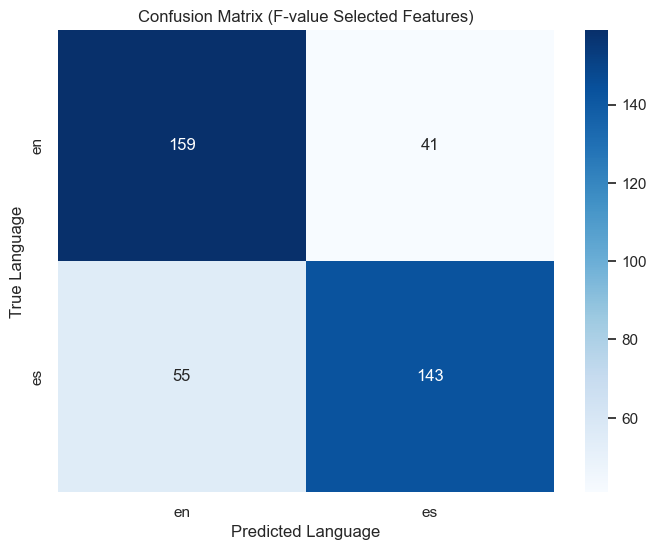


--- Random Forest with Mutual Information Selected Features ---

Classification Report (Mutual Information):
              precision    recall  f1-score   support

          en       0.78      0.84      0.81       200
          es       0.83      0.76      0.79       198

    accuracy                           0.80       398
   macro avg       0.81      0.80      0.80       398
weighted avg       0.81      0.80      0.80       398


Confusion Matrix (Mutual Information):


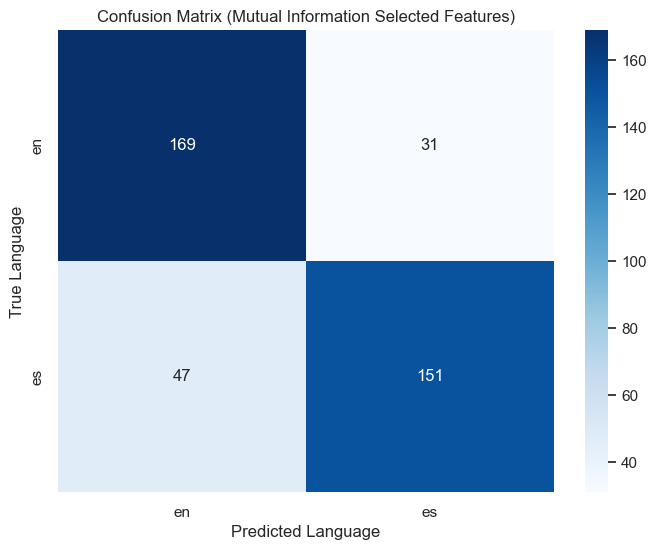

In [20]:
# Train and evaluate Random Forest with F-value selected features
print("\n--- Random Forest with F-value Selected Features ---")
rf_model_f = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_f.fit(X_train_f, y_train_lang)
y_pred_f = rf_model_f.predict(X_test_f)

print("\nClassification Report (F-value):")
print(classification_report(y_test_lang, y_pred_f))

print("\nConfusion Matrix (F-value):")
cm_f = confusion_matrix(y_test_lang, y_pred_f)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model_f.classes_, yticklabels=rf_model_f.classes_)
plt.title('Confusion Matrix (F-value Selected Features)')
plt.xlabel('Predicted Language')
plt.ylabel('True Language')
plt.show()

# Train and evaluate Random Forest with Mutual Information selected features
print("\n--- Random Forest with Mutual Information Selected Features ---")
rf_model_mi = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_mi.fit(X_train_mi, y_train_lang)
y_pred_mi = rf_model_mi.predict(X_test_mi)

print("\nClassification Report (Mutual Information):")
print(classification_report(y_test_lang, y_pred_mi))

print("\nConfusion Matrix (Mutual Information):")
cm_mi = confusion_matrix(y_test_lang, y_pred_mi)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mi, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model_mi.classes_, yticklabels=rf_model_mi.classes_)
plt.title('Confusion Matrix (Mutual Information Selected Features)')
plt.xlabel('Predicted Language')
plt.ylabel('True Language')
plt.show()

In [21]:
# Define features (X) and target variable (y_word) for word classification
X = all_features_df.drop(columns=['word', 'language'])
y_word = all_features_df['word']

# Split data into training and testing sets for word classification
# Stratify by y_word to ensure balanced representation of each word
X_train, X_test, y_train_word, y_test_word = train_test_split(X, y_word, test_size=0.2, random_state=42,
                                                              stratify=y_word)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_word shape: {y_train_word.shape}")
print(f"y_test_word shape: {y_test_word.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train shape: (1590, 14784)
X_test shape: (398, 14784)
y_train_word shape: (1590,)
y_test_word shape: (398,)


In [ ]:
# Feature Selection using ANOVA F-value for Word Classification
print("\n--- Feature Selection (ANOVA F-value) for Word Classification ---")
# Adjust k if necessary, keeping it reasonably high for a multi-class problem
selector_f_word = SelectKBest(f_classif, k=500)
X_train_f_word = selector_f_word.fit_transform(X_train_scaled, y_train_word)
X_test_f_word = selector_f_word.transform(X_test_scaled)

print(f"Shape after F-value selection: X_train_f_word {X_train_f_word.shape}, X_test_f_word {X_test_f_word.shape}")

# Feature Selection using Mutual Information for Word Classification
print("\n--- Feature Selection (Mutual Information) for Word Classification ---")
# Adjust k if necessary
selector_mi_word = SelectKBest(mutual_info_classif, k=500)
X_train_mi_word = selector_mi_word.fit_transform(X_train_scaled, y_train_word)
X_test_mi_word = selector_mi_word.transform(X_test_scaled)

print(
    f"Shape after Mutual Information selection: X_train_mi_word {X_train_mi_word.shape}, X_test_mi_word {X_test_mi_word.shape}")


--- Feature Selection (ANOVA F-value) for Word Classification ---


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [   42    43    85 ... 12141 12142 12143] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Shape after F-value selection: X_train_f_word (1590, 500), X_test_f_word (398, 500)

--- Feature Selection (Mutual Information) for Word Classification ---
